In [9]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import jax.numpy as jnp
import numpy as np
import os
from matplotlib import pyplot as plt

import sys
sys.path.append('../')
import field_level.inference as inference

!nvidia-smi --query-gpu=gpu_name --format=csv,noheader

NVIDIA A100-PCIE-40GB


### Example of the field-level inference for the linear Gaussian field with $64^3$ ICs in 2000 $\mathrm{Mpc}/h$ box and $k_\mathrm{max}=0.1~h/\mathrm{Mpc}$

In [3]:
### parameters

boxsize = 2000.0
redshift = 0.5
which_pk = 'cosmo'

data_path = f'../mock_data/{which_pk}_{boxsize}_z{redshift}_gauss_8.0_128.npy'
save_path = './results/gauss'
if not os.path.exists('./results'):
    os.mkdir('./results')

ics_params = ['varied_ics', 0] 
### 0 specifies not saving the samples of modes, if you set 1 the samples of modes are also saved (but be careful that its size would be huge).

model_name = 'gauss'

ng_params = [64, 64, 128] 
### the number of ICs, the number of particles, and the number of assignment grid (the last twos are not relevant for gaussian case)

mas_params = [2, 1]
### the interpolation order of assignment, and the interlace or not. Again, this is not relevant for the gaussian run

which_space = 'k_space'
### In which space the likelihood is evaluated. Now only 'k_space' is suppoerted

cosmo_params = {'A':1.0, 'oc': 0.11933, 'hubble': 0.73}
#cosmo_params = {'sigma8':0.835, 'oc': 0.11933, 'hubble': 0.73}

bias_params = {}

err_params = {'fixed_log_Perr':8.0}
### for the fixed value of the noise in the likelihood. If you would like to vary it, set 'log_Perr':8.0.

kmax = 0.1

dense_mass = [('A', 'oc', 'hubble')]
#dense_mass = [('sigma8', 'oc', 'hubble')]

mcmc_params = [0, 1, 5000, 1000, 0.8, 2004, 0]
### i-th chain, thinning, the number of samples, the number of warmup, the target acceptance rate, random seed for mcmc, and the number of the previously collected samples divied by 100 (to restart)


In [4]:
### run inferencne

inference.field_inference(boxsize, redshift, which_pk,
                          data_path, save_path,
                          ics_params,
                          model_name, ng_params, mas_params, which_space,
                          cosmo_params, bias_params, err_params, kmax,
                          dense_mass, mcmc_params)

varied_ics
fixed_log_Perr =  8.0
cic interlacing on
ng =  64
ng_L =  64
ng_E =  128
kmax =  0.1
model =  gauss


idx_conjugate_real_kmax.shape =  (67647,)
idx_conjugate_imag_kmax.shape =  (67647,)
Loading the data from ../mock_data/cosmo_2000.0_z0.5_gauss_8.0_128.npy...
Done.
datak_1d_ind.shape = 
(135042,)
save params =  ['A', 'oc', 'hubble', 'sigma8', 'H0', 'OM']
min_pe_params =  ['A', 'oc', 'hubble', 'sigma8', 'H0', 'OM', 'gauss_1d']
dense_mass =  [('A', 'oc', 'hubble')]
save_base =  ./results/gauss
rng_seed =  2004
{('A', 'oc', 'hubble'): Array([[ 0.01117101, -0.00797713, -0.04313484],
       [-0.00797713,  0.00627292,  0.02920528],
       [-0.04313484,  0.02920528,  0.17855457]], dtype=float64), ('gauss_1d',): Array([0.82435657, 0.89834264, 1.07703383, ..., 0.40971026, 0.38742511,
       0.50282198], dtype=float64)}
i_warmup =  1
while =  False
running batch 0 ...
Min of the potential energy =  -483631.1054597707
min_pe_samples[A] =  1.0247413351770316
min_pe_samples[oc] =  0.11532728922458588
min_pe_samples[hubble] =  0.7167503556355661
min_pe_samples[sigma8] =  0.8338647448906669
min_pe_sa

In [5]:
### load samples

params = []

params += cosmo_params.keys()

if 'A' in cosmo_params.keys():
    params += ['sigma8']
if 'sigma8' in cosmo_params.keys():
    params += ['A']
if 'hubble' in cosmo_params.keys():
    params += ['H0']
if 'hubble' in cosmo_params.keys() or 'oc' in cosmo_params.keys():
    params += ['OM']

params += bias_params.keys()

if 'fixed_log_Perr' in err_params.keys():
    fixed_log_Perr = err_params.pop('fixed_log_Perr')
    print('fixed_log_Perr = ', fixed_log_Perr, file=sys.stderr)
else:
    params += err_params.keys()


sample_dict = {}
i_chain = mcmc_params[0]
for param in params:
    sample_dict[param] = np.loadtxt(save_path + f'_{param}_chain{i_chain}.dat')

array([[<Axes: title={'center': 'A'}>, <Axes: title={'center': 'A'}>],
       [<Axes: title={'center': 'oc'}>, <Axes: title={'center': 'oc'}>],
       [<Axes: title={'center': 'hubble'}>,
        <Axes: title={'center': 'hubble'}>],
       [<Axes: title={'center': 'sigma8'}>,
        <Axes: title={'center': 'sigma8'}>],
       [<Axes: title={'center': 'H0'}>, <Axes: title={'center': 'H0'}>],
       [<Axes: title={'center': 'OM'}>, <Axes: title={'center': 'OM'}>]],
      dtype=object)

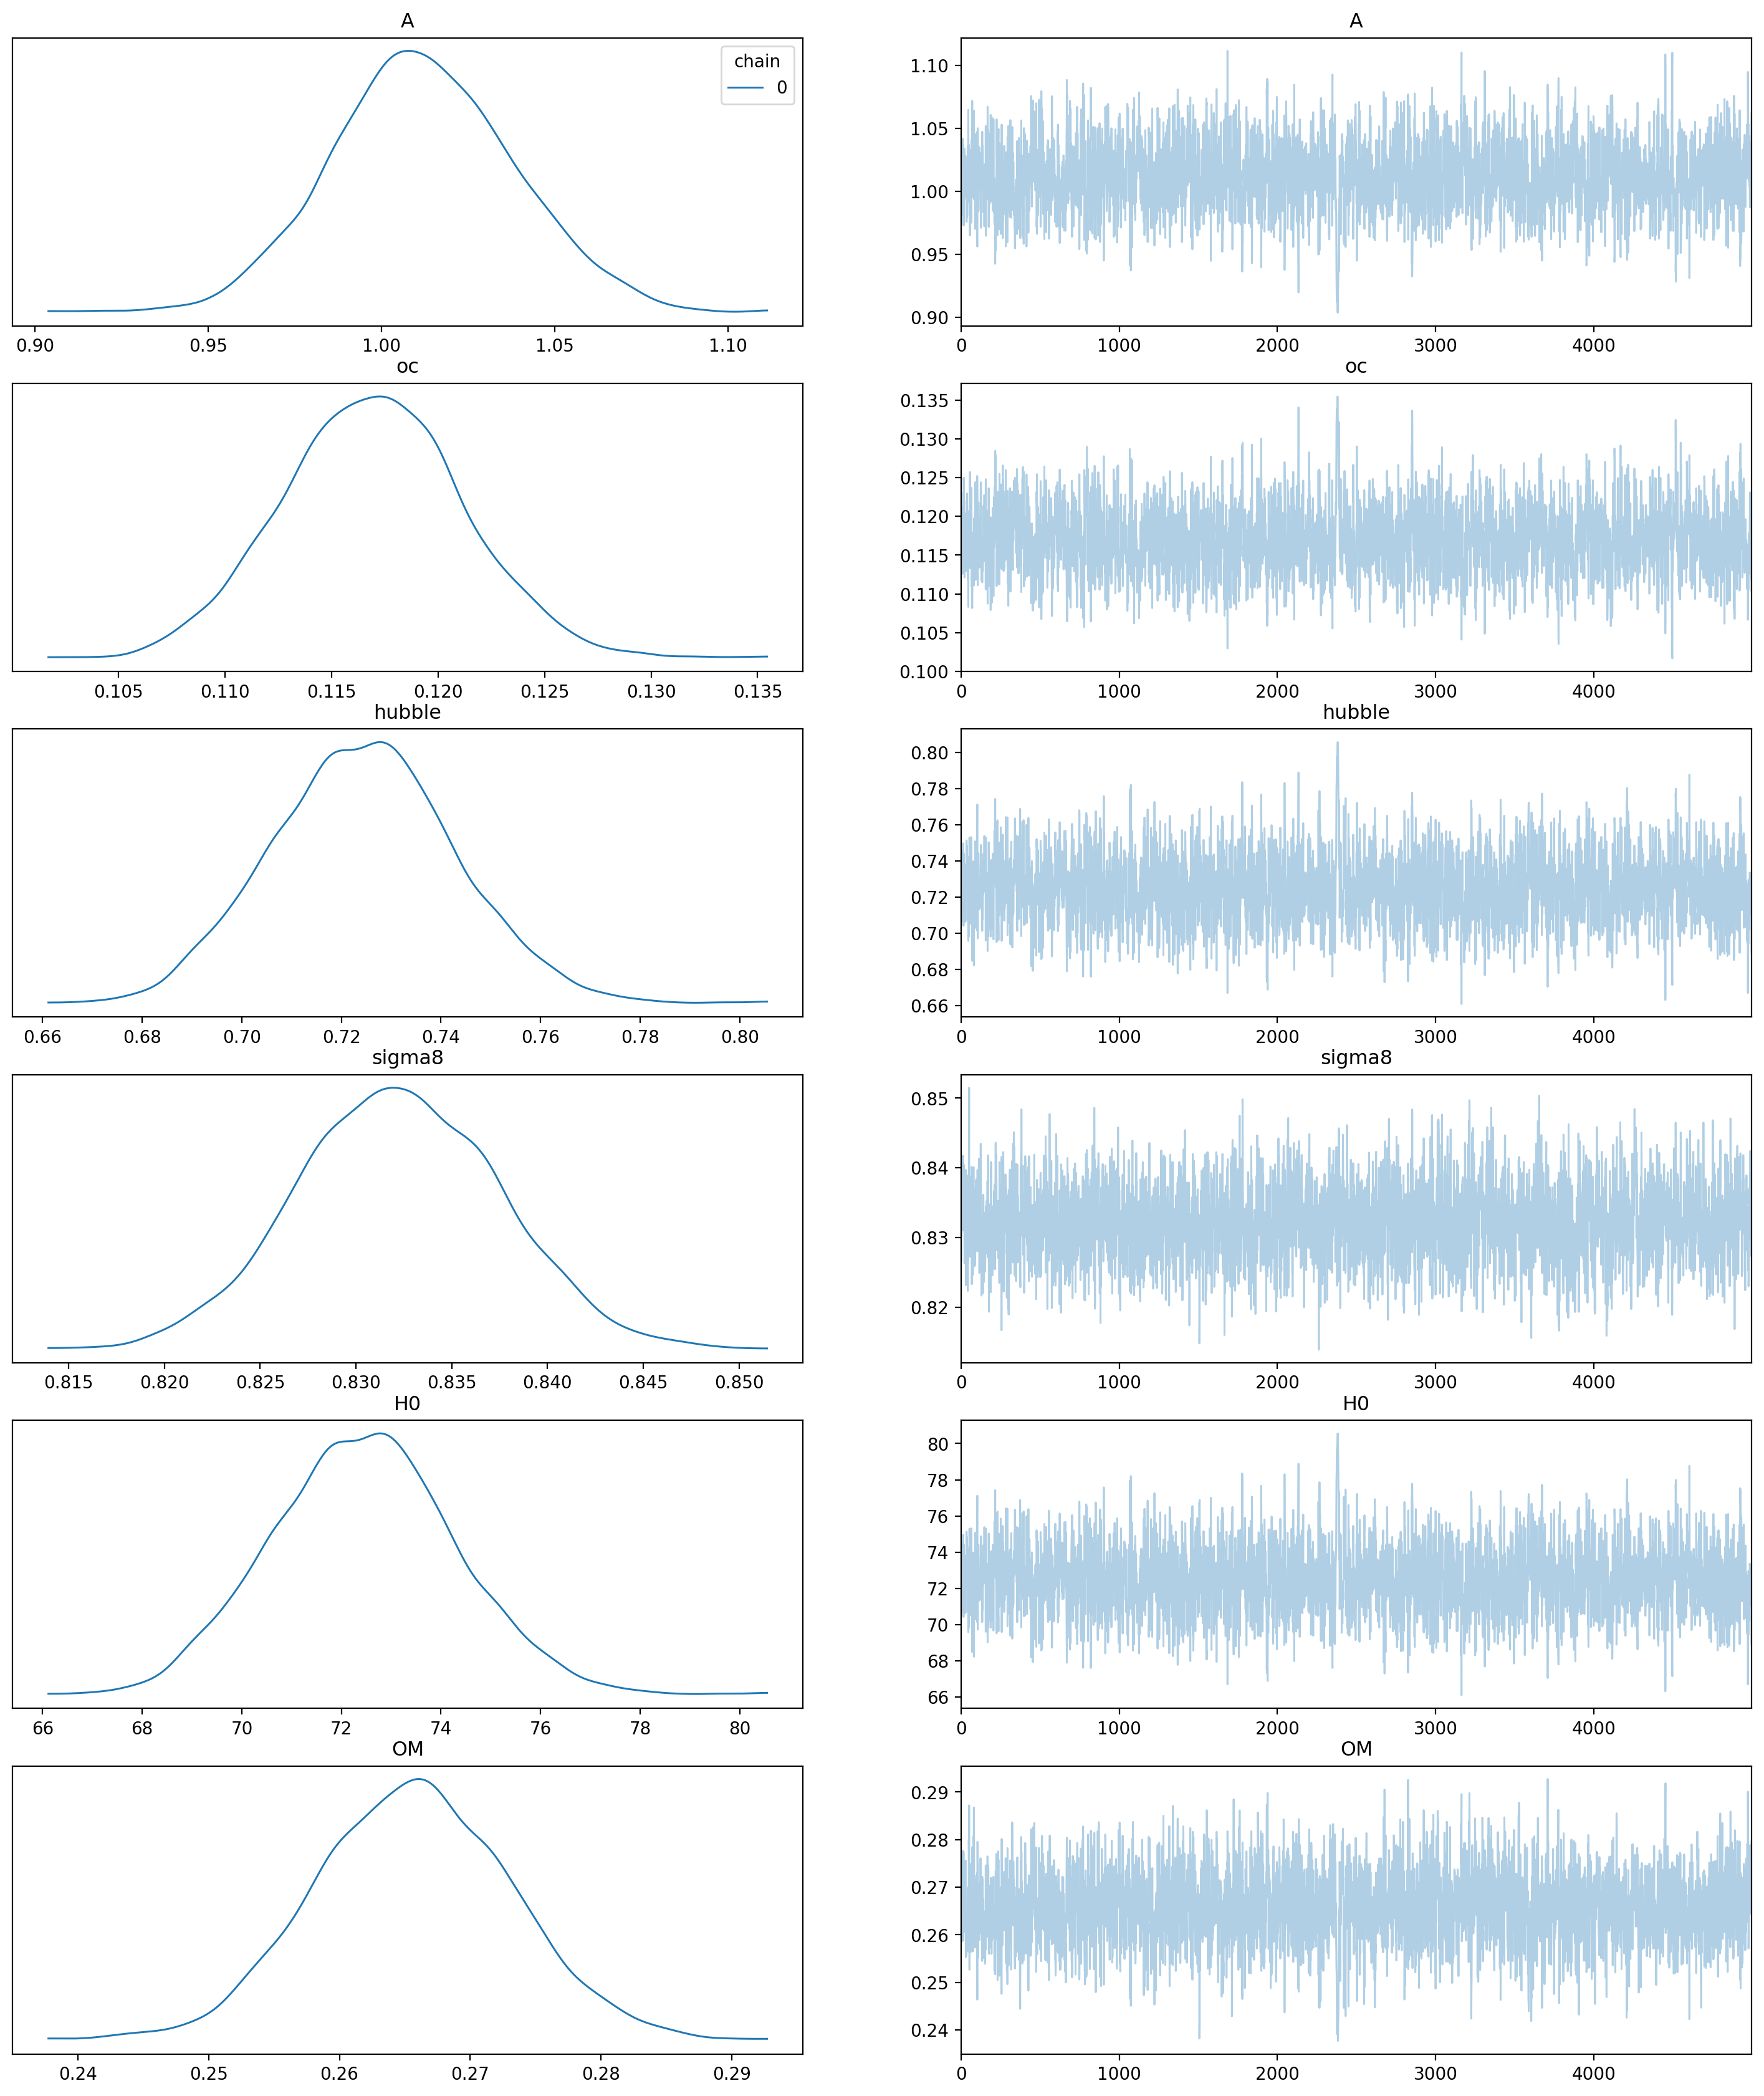

In [6]:
import arviz as az

az.plot_trace(sample_dict, legend=True, compact=False, figsize=(18,3.5*len(sample_dict)))

In [7]:
### show posterior contour

from getdist import plots, MCSamples
import getdist

contour_params = ['A', 'sigma8', 'oc', 'H0']

labels = ['A', '\sigma_8', '\omega_\mathrm{cdm}', 'H_0']

samples = []
for contour_param in contour_params:
    samples += [sample_dict[contour_param]]
    
plot_samples = MCSamples(samples=samples, 
                         names = contour_params,
                         labels = labels)

Removed no burn in


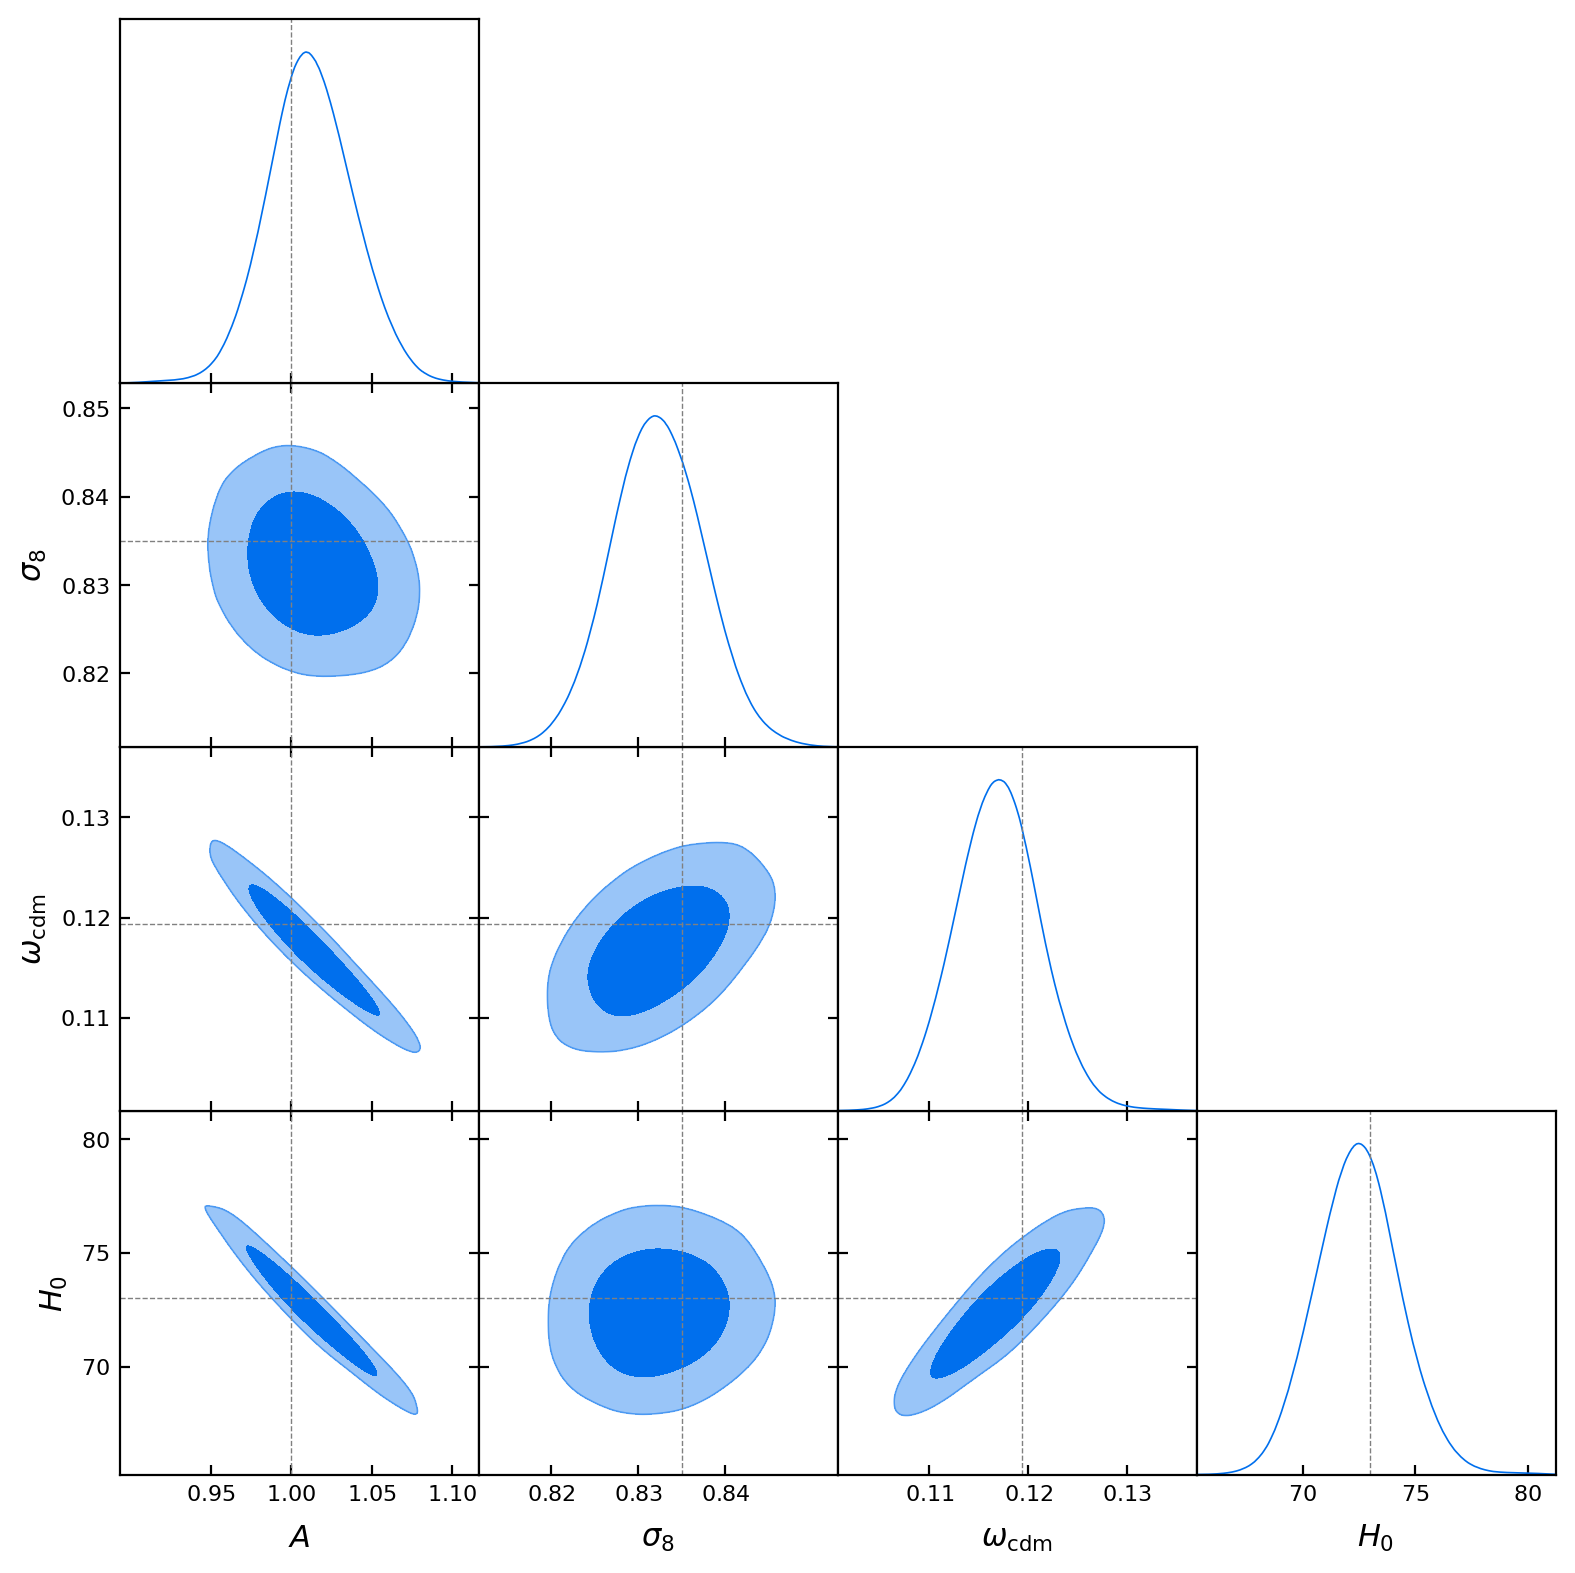

In [13]:
g = plots.get_subplot_plotter()
g.triangle_plot([plot_samples], 
                filled=True,
                markers={'A':1.0, 'sigma8':0.835, 'oc': 0.11933, 'H0':73.0})